# US GDP vs. SPX: Holt-Winters time-series forecasting

We examine the US gross domestic product's relationship to the 
US equity market (S&P500), in real terms. Forecasts for both are 
demonstrated using *Holt-Winters* time-series model. 
We derive the most likely range for real GDP growth, and 
identify excessive equity valuations aside from inflationary pressures.

Our analysis would suggest the following
***back of the envelope calculation***: say, SPX nominally has an annual gain of 6%
and inflation stands at 2%, then the real SPX gain is 4%.
Take half of that to arrive at real GDP growth: 2%.
*Helpful because GDP numbers are announced after months of lag.*

*Dependencies:*

- Repository: https://github.com/rsvp/fecon235
- Python: matplotlib, pandas

*CHANGE LOG*
     
    2017-04-09  Fix issue #2, update data and narrative, optimize HW parameters.
                   Closing note on Didier Sornette research.
    2015-02-20  Code review and revision.
    2014-08-11  First version uses major revision yi_fred.

In [1]:
from fecon235.fecon235 import *

In [2]:
#  PREAMBLE-p6.15.1223 :: Settings and system details
from __future__ import absolute_import, print_function
system.specs()
pwd = system.getpwd()   # present working directory as variable.
print(" ::  $pwd:", pwd)
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2
#       Use 0 to disable this feature.

#  Notebook DISPLAY options:
#      Represent pandas DataFrames as text; not HTML representation:
import pandas as pd
pd.set_option( 'display.notebook_repr_html', False )
from IPython.display import HTML # useful for snippets
#  e.g. HTML('<iframe src=http://en.mobile.wikipedia.org/?useformat=mobile width=700 height=350></iframe>')
from IPython.display import Image 
#  e.g. Image(filename='holt-winters-equations.png', embed=True) # url= also works
from IPython.display import YouTubeVideo
#  e.g. YouTubeVideo('1j_HxD4iLn8', start='43', width=600, height=400)
from IPython.core import page
get_ipython().set_hook('show_in_pager', page.as_hook(page.display_page), 0)
#  Or equivalently in config file: "InteractiveShell.display_page = True", 
#  which will display results in secondary notebook pager frame in a cell.

#  Generate PLOTS inside notebook, "inline" generates static png:
%matplotlib inline   
#          "notebook" argument allows interactive zoom and resize.

 ::  Python 2.7.13
 ::  IPython 5.1.0
 ::  jupyter_core 4.2.1
 ::  notebook 4.1.0
 ::  matplotlib 1.5.1
 ::  numpy 1.11.0
 ::  pandas 0.19.2
 ::  pandas_datareader 0.2.1
 ::  Repository: fecon235 v5.17.0221 develop
 ::  Timestamp: 2017-04-12, 01:14:38 UTC
 ::  $pwd: /media/yaya/virt15h/virt/dbx/Dropbox/ipy/fecon235/nb


## Holt-Winters equations and code

We adopt the Holt-Winters notation from Rob Hyndman's book, 
*Forecasting with Exponential Smoothing* (2008), ignoring the seasonal aspect of the H-W model.

Our Python module `yi_timeseries.py` contains the core of model, see
https://github.com/rsvp/fecon235/blob/master/lib/yi_timeseries.py

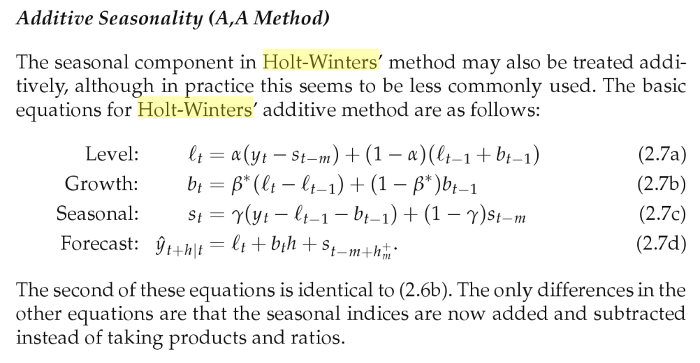

In [3]:
#  Note that y represents the raw series in the equations.
#  We use Y as a generic label in dataframes.

Image(filename='holt-winters-equations.png', embed=True)

## Working with dataframes

We now get **data** for real US GDP into a pandas DataFrame.
Our Holt-Winters functions generally accept dataframes as arguments
(but computation in the background is using numpy arrays,
and we let the *fecon235* API abstract the messy details).
The user interface is designed to easily get the job done.

In [4]:
#  Retrieve quarterly data for real US GDP as DataFrame:
dfy = get( q4gdpusr )

That quarterly data comes from FRED (Federal Reserve Bank, St. Louis),
seasonally adjusted and expressed in billions of 2009 dollars.

In [5]:
#  So we are currently discussing a 17 trillion dollar economy...
tail( dfy )

                  Y
T                  
2015-04-01  16374.2
2015-07-01  16454.9
2015-10-01  16490.7
2016-01-01  16525.0
2016-04-01  16583.1
2016-07-01  16727.0
2016-10-01  16813.3

In [6]:
#  DEFINE start YEAR OF ANALYSIS:
start = '1980'

#  We can easily re-run the entire notebook from different start date.

Holt-Winters requires specification of two parameters,
**alpha** and **beta**, which sometimes are guessed.
Our default values have been found in practice to be 
good *a priori* choices (see Gelper 2007, ibid.):

In [7]:
print(hw_alpha, hw_beta, " :: DEFAULT Holt-Winters alpha and beta")

0.26 0.19  :: DEFAULT Holt-Winters alpha and beta


### Optimizing Holt-Winters parameters

We developed an algorithm to optimize those parameters,
conditional on specific data. See
https://github.com/rsvp/fecon235/blob/master/lib/ys_opt_holt.py

In [8]:
#  This optimization procedure may be computationally intensive
#  depending on data size and the number of grids,
#  so uncomment the next command to run it:

ab = optimize_holt( dfy['1980':], grids=50 )

ab

 !.  WARNING: __main__.py Optimizing Holt-Winters alphabetaloss may take TIME!


[0.9388, 0.2245, 0.2126, 35.739584510104578]

The first two elements in the *ab* list are alpha and beta respectively.
The third element gives the median absolute loss as percent
for an one-step ahead forecast given those parameters.
The fourth element is the median absolute loss
(which indicates we have used a L1 loss function
for robust optimization).

2017-04-09: For start='1980', median absolute loss of 0.21% is respectable. 

In [9]:
#  Let's use the optimized values for alpha and beta
#  to compute the Holt dataframe:

holtdf = holt( dfy, alpha=ab[0], beta=ab[1] )

In [10]:
stats( holtdf[start:] )
#  Summary stats from custom start point:

                  Y         Level      Growth
count    148.000000    148.000000  148.000000
mean   11470.863514  11470.784096   68.695330
std     3238.250597   3238.355570   39.795440
min     6382.900000   6384.321000  -87.758692
25%     8749.000000   8749.651230   51.976210
50%    11505.800000  11504.636809   72.513945
75%    14592.850000  14598.388106   95.063670
max    16813.300000  16812.880080  144.547727

 ::  Index on min:
Y        1980-07-01
Level    1980-07-01
Growth   2009-01-01
dtype: datetime64[ns]

 ::  Index on max:
Y        2016-10-01
Level    2016-10-01
Growth   2000-04-01
dtype: datetime64[ns]

 ::  Head:
                 Y        Level     Growth
T                                         
1980-01-01  6524.9  6526.504564  39.445264
1980-04-01  6392.6  6403.209009   2.909950
1980-07-01  6382.9  6384.321000  -1.983692
 ::  Tail:
                  Y         Level     Growth
T                                           
2016-04-01  16583.1  16584.138088  68.284753
2016-07-0

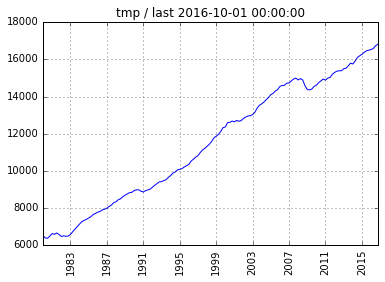

In [11]:
#  Y here is the raw series, i.e. real GDP in billions of dollars:
plot( holtdf['Y'][start:] )

In [12]:
#  Annualized geometric mean return of the raw series:
georet( todf(holtdf['Y'][start:]), yearly=4 )

#  Since 1980, real GDP growth is about 2.6%

[2.58, 2.59, 1.46, 4, 148, '1980-01-01', '2016-10-01']

In [13]:
#  Level can be thought of as the smoothed series:

# plot( holtdf['Level'][start:] )

In [14]:
#  Growth is the fitted slope at each point,
#  expressed in units of the original series:

# plot( holtdf['Growth'][start:] )

But we are most interested in the *forecasted*
annualized growth rate in percentage terms.
The specialized function *holtpc* handles that need.

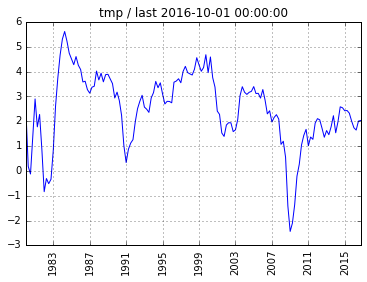

In [15]:
pc = holtpc( dfy, yearly=4, alpha=ab[0], beta=ab[1] )
plot( pc[start:] )

In [16]:
gdp_forecast = tailvalue( pc )
gdp_forecast

2.0329366789936247

That *tailvalue* of pc gives us the **latest forecast
for real GDP growth over the next year**.
But to understand its precision,
we examine the big picture.

### Big GDP Trend for discerning precision

 ::  regresstime slope = -0.0061459975175


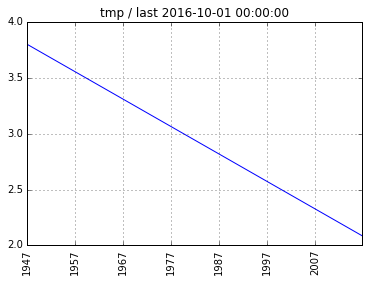

In [17]:
#  Here is the BIG GDP TREND since the end of World War 2:

trendpc = trend( pc )

plot( trendpc )

In [18]:
stat( trendpc )

                Y
count  280.000000
mean     2.943414
std      0.497661
min      2.086048
25%      2.514731
50%      2.943414
75%      3.372098
max      3.800781


Projected annualized real GDP growth has decreased from 3.8% post-WW2 
to 2.1% most recently over the long time scale.

Using our *detrend* function we can visualize the local fluctuations
around the BIG GDP TREND.

 ::  regresstime slope = -0.0061459975175


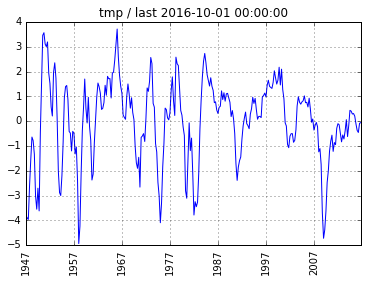

In [19]:
detpc = detrend( pc )
plot( detpc )

In [20]:
stat( detpc )

                  Y
count  2.800000e+02
mean  -6.875453e-16
std    1.655007e+00
min   -4.929548e+00
25%   -8.177042e-01
50%    1.973708e-01
75%    1.115531e+00
max    3.720233e+00


Standard deviation = 1.66 for the variation around the BIG GDP TREND. 
So at 2\*std, we are roughly looking at +/- 3.3 percentage points around the long-term trend. 

2017-04-10:  We can see from *detpc* that the United States has recovered 
from the Great Recession to mean GDP growth. "Doing just OK, ah, on average..." 

A band of two standard deviations from +2.1 gives us a ***forward estimated range of 
(horrible) -1.2% to (great) +5.4% for real GDP growth.***

## Real GDP forecast using Holt-Winters

By fitting Level and Growth, Holt-Winters essentially uses 
the slope to make point forecasts forward in time.
We show an alternate, more direct, way to arrive at our forecast.

In [21]:
#  Forecast real GDP, four quarters ahead:
foregdp = holtforecast( holtdf, h=4 )
foregdp

       Forecast
0  16813.300000
1  16898.328881
2  16983.777683
3  17069.226484
4  17154.675286

In [22]:
#  Forecast real GDP rate of GROWTH, four quarters ahead:
100 * ((foregdp.iloc[4] / foregdp.iloc[0]) - 1)

Forecast    2.030388
dtype: float64

We thus have computed the **Holt-Winters forecast for real GDP rate for the year ahead:**
2.03% (as of 2017-04-10)

This should concur with our *holtpc* method above, i.e. *gdp_forecast*. 

Note that foregdp.iloc[0] is the last actual data point, rather than the last Level.

In [23]:
#  We can plot the point forecasts 12 quarters ahead (i.e. 3 years):

# plotholt( holtdf, 12 )

## Real GDP vs. real SPX (S&P 500)

This section covers the measured economy of goods and services, 
versus the market valuation of equity shares.

In [24]:
#  SPX is a daily series, but we can directly retrieve its monthly version:
spx = get( m4spx )

#  ... to match the monthly periodicity of our custom deflator:
defl = get( m4defl )

 ::  S&P 500 prepend successfully goes back to 1957.


In [25]:
#  Now we synthesize a quarterly real SPX version by resampling:
spdefl = todf( spx * defl )
spq = quarterly( spdefl )

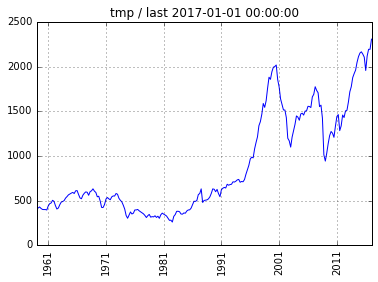

In [26]:
#  Real SPX resampled quarterly in current dollars:
plot( spq )

In [27]:
#  Geometric mean return for real SPX:
georet( spq[start:], yearly=4 )

#  cf. volatility for real GDP = 1.5% 
#      in contrast to equities = 13.2%

[5.36, 6.23, 13.2, 4, 149, '1980-01-01', '2017-01-01']

**In real terms, the geometric mean return of SPX is double that of GDP.** 

Next, we examine their correlation.
For start='1980' ***their correlation is around +0.9 which is fairly strong.***

In [28]:
stat2( dfy['Y'][start:], spq['Y'][start:] )

 ::  FIRST variable:
count      148.000000
mean     11470.863514
std       3238.250597
min       6382.900000
25%       8749.000000
50%      11505.800000
75%      14592.850000
max      16813.300000
Name: Y, dtype: float64

 ::  SECOND variable:
count     149.000000
mean     1118.668173
std       587.281565
min       260.527933
25%       579.892749
50%      1170.186413
75%      1554.175713
max      2308.843477
Name: Y, dtype: float64

 ::  CORRELATION
0.904455183426
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     656.4
Date:                Tue, 11 Apr 2017   Prob (F-statistic):           6.92e-56
Time:                        18:16:41   Log-Likelihood:                -1279.7
No. Observations:                 148   AIC:             

The linear regression shows approximately that $dG / dS = 5.0$

Therefore using mean values g and s: $ (dG/g) / (s/dS) = 5.0 * (s/g) $

The right-hand side can be roughly interpreted as the ratio between percentage changes.

In [29]:
#  2017-04-09, for start='1980':  5.0 * (s/g) = 

gsratio = 5.0 * div(spq[start:].mean(), dfy[start:].mean())
gsratio = gsratio.values[0]
gsratio

0.48761288617013465

Thus **1% rise (100 bp) in real SPX would suggest additional 49 bp in real US GDP growth** 
(we note that regression $R^2 = 0.82$, so this seems reasonable). 

SPX is generally regarded as a leading economic indicator. 
(The regression fit improves if *start* is moved farther back.)

***Back of the envelope calculation***: say, SPX nominally has an annual gain of 6%
and inflation stands at 2%, then the real SPX gain is 4%.
Take half of that to arrive at real GDP growth: 2%.
*Helpful because GDP numbers are announced after months of lag.*

## Real SPX forecast using Holt-Winters

Given that the log returns of SPX approximately follow an AR(1) process with unit root,
we will resort to using our default values for alpha and beta 
which are ideal for smoothing a time-series with such characteristics.

Accordingly, we shall look at projected (not actual) annual rates of return, 
rather than generating point forecasts.

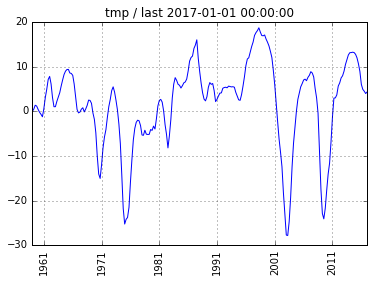

In [30]:
#       holtpc should be familiar from our GDP analysis.
pcspq = holtpc( spq, yearly=4, alpha=hw_alpha, beta=hw_beta )
plot( pcspq )

#  Note we use all data since 1957.

In [31]:
spx_forecast = tailvalue( pcspq )
spx_forecast

4.36048159499744

Real SPX returns are very volatile, especially on the downside.

2017-04-10: SPX is trading near all-time highs,
and **Holt-Winters is forecasting +4.4% annualized over the next year**.
Worth noting that the *real* rate is being projected, 
thus if inflation stands at 2%, the *nominal* rate of return will be +6.4%.


### SPX over the long haul, bubbles and crashes

So let's now look at the long-term trend in projected SPX rate of returns.

 ::  regresstime slope = 0.0185216267691


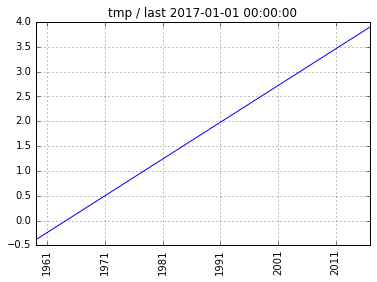

In [32]:
trend_pcspq = trend( pcspq )
plot( trend_pcspq )

There are several major episodes of less than -20% forecasted on smoothed real SPX, but 
over the long-term US equities are showing increasingly better returns against inflation.

(Curiously, in contrast, the long-term trend for real GDP growth was *downwards*.)

To help identify local **BUBBLES**, i.e. excessive equity valuations 
apart from inflationary effects, we detrend the series as follows:

 ::  regresstime slope = 0.0185216267691


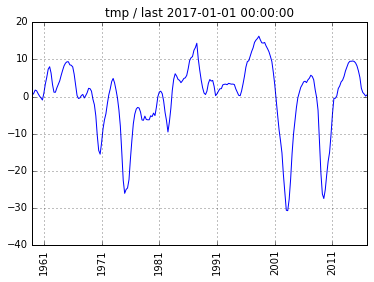

In [33]:
det_pcspq = detrend( pcspq )
plot( det_pcspq )

In the plot above, we have filtered out both inflation and the underlying 
real rate of return on equities, leaving us with a picture of *extreme* valuations 
in the short-term.

**The shift from overvaluation to collapse is very swift, 
and occurs historically on a regular but unpredictable basis.** 
***Instability is the norm.***

## Further research

*What are the arrival times of collapses in equity valuations?
Are there signals which can be identified as precursors to such collapses?*

There are structural similarities to the prediction of earthquakes
where threshold tremors can be regarded as precursors.

[Didier Sornette](https://scholar.google.com/citations?user=HGsSmMAAAAAJ&hl=en)
has discovered log-periodic times, inspired by geophysics and self-organizing
systems. A separate notebook will be dedicated to his findings regarding
criticality: bubbles and anti-bubbles in financial markets.